# Credit Card Fraud Detection - Exploratory Data Analysis (EDA) 

## Goals of this notebook: 
1. Loads the dataset and verifies its basic integrity (shape, columns, missing values) 
2. Quantifies class imbalance (fraud is very rare in this dataset) 
3. Visualizes simple distributions (target, Amount, Time) 
4. Identifies implications for modelling (accuracy is misleading, precision/recall are preferred) 

In [16]:
# Imports + Preliminary Settings
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

plt.rcParams["figure.dpi"] = 120 

## 1) Load Data 

Make sure you've gone to the kaggle website and placed the `creditcard.csv` file into `../data/raw/creditcard.csv` (this folder is gitignored so it will be empty when you clone)  

Next, we'll load the csv and see how the data is 

In [17]:
DATA_PATH = "../data/raw/creditcard.csv" 
df = pd.read_csv(DATA_PATH) 

print("Shape:", df.shape) 
df.head() 

Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2) Basic Schema 

We will inspect column names and data types to understand what we're working with. 
The target label should be `Class` taking values: 
- `0` = legitimate transaction 
- `1` = fraud 

In [18]:
df.columns, df.dtypes.head() 

(Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
        'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
        'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
        'Class'],
       dtype='object'),
 Time    float64
 V1      float64
 V2      float64
 V3      float64
 V4      float64
 dtype: object)

## 3) Missing Values 

Before modelling anything, we have to check how clean our dataset is, i.e. whether there are missing values 

If there are missing values, we have to decide how we want to handle them, whether to impute, drop, or otherwise

In [19]:
missing = df.isna().sum().sort_values(ascending=False) 
missing.head(15)

Time    0
V1      0
V2      0
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
V10     0
V11     0
V12     0
V13     0
V14     0
dtype: int64

## 4) Class imbalance (the main issue for this dataset) 

Generally, fraud detection is usually an *imbalanced classification* problem: 
- Most transactions are real 
- The cases of fraud are very rare in the dataset 

This matters because certain evaluation metrics, like accuracy, can become very misleading. 

If 0.1% of the data is fraud, then a trivial and naive model that always predicts 'real' will have 99.9% accuracy even though the model is useless 

To account for this we will inspect the fraud rate and visualize the imbalance 

In [20]:
target_col = "Class" 
counts = df[target_col].value_counts() 
fraud_rate = counts.get(1, 0) / counts.sum() 

print(counts) 
print(f"Fraud rate: {fraud_rate:.6f} ({fraud_rate*100:.4f}%)") 

Class
0    284315
1       492
Name: count, dtype: int64
Fraud rate: 0.001727 (0.1727%)


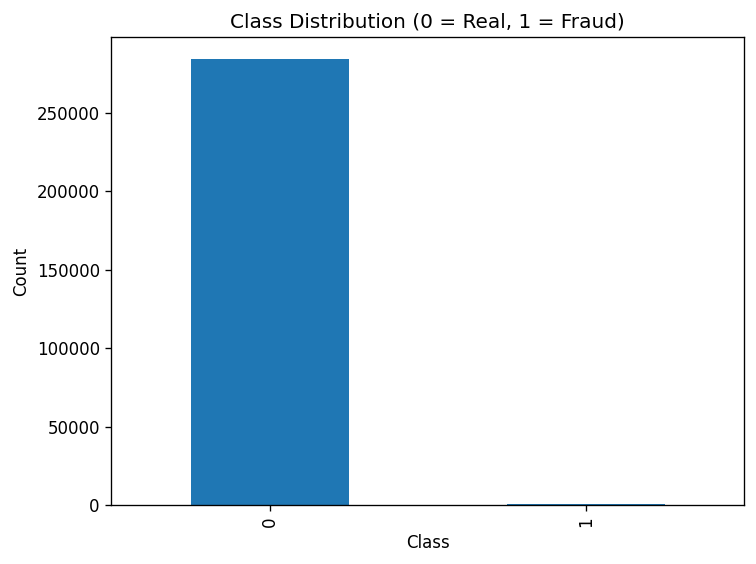

In [21]:
ax = counts.sort_index().plot(kind="bar") 
ax.set_title("Class Distribution (0 = Real, 1 = Fraud)")
ax.set_xlabel("Class") 
ax.set_ylabel("Count") 
plt.tight_layout() 
plt.show() 

## 5) Transaction Amount and Time Distributions 

A couple of interpretable features of the data set are: 
- `Amount`: transaction amount 
- `Time`: seconds elapsed from the first transaction in the dataset 

Looking at their distributions will help us find: 
- scaling/transformation patterns (e.g., log transform for Amount) 
- whether they have any daily patterns
- etc... 



In [22]:
df["Amount"].describe() 

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

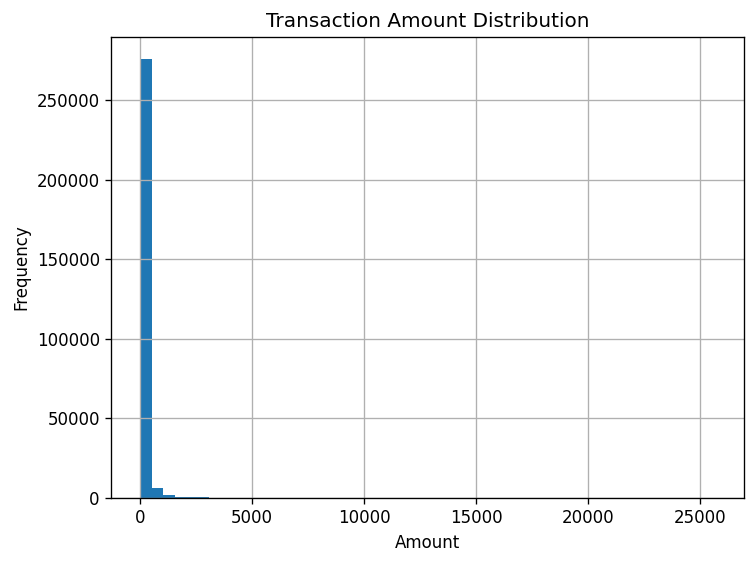

In [23]:
df["Amount"].hist(bins=50) 
plt.title("Transaction Amount Distribution") 
plt.xlabel("Amount")  
plt.ylabel("Frequency")
plt.tight_layout()
plt.show() 

In [24]:
df.groupby(target_col)["Amount"].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87


In [25]:
df["Time"].describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

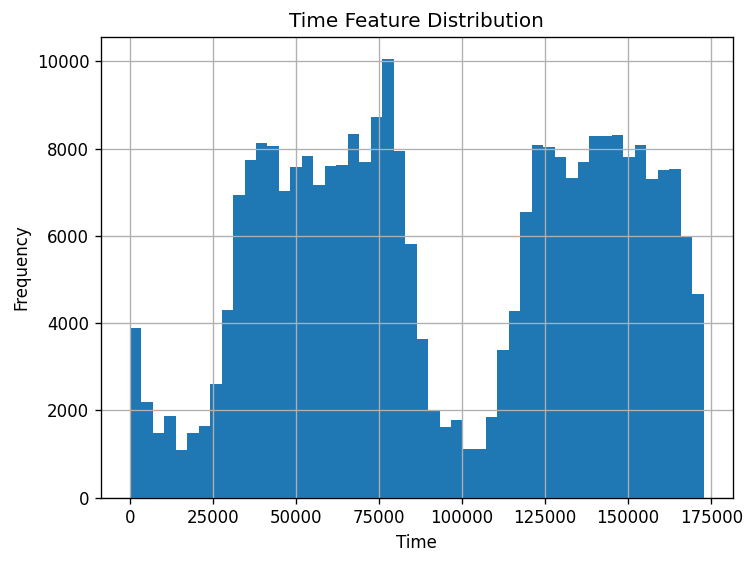

In [26]:
df["Time"].hist(bins=50) 
plt.title("Time Feature Distribution") 
plt.xlabel("Time") 
plt.ylabel("Frequency") 
plt.tight_layout() 
plt.show() 

## 6) Summary & Next Notebook

### What we learned: 
- The dataset is highly imbalanced (fraud is very rare)
- `Amount` is heavily skewed (large range, large outliers, likely benefits from certain scaling or transformations) 
- `Time` has a wide range and may even follow periodic behaviour

### Modelling: 
Because of this imbalance, our evaluation should focus on: 
- **Precision**: proportion of the model's fraud flags that are actually correct 
- **Recall**: proportion of all fraud that was correctly flagged by the model 
- **Precision-Recall Area Under The Curve (PR-AUC)**: in imbalanced settings, this metric is often more informative than the ROC-AUC or F1 score (other common binary classification metrics)

### Next Notebook 
In the next notebook, we will be training and testing several models, establishing some baseline tree models first, and then comparing them to some more advanced models after
